In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from database_credentials import get_database_url
from load_drop_data import (
    load_week_n_sell_data,
    drop_incomplete_sell_data
)

In [57]:
def date_to_weekday_am_pm(date):
    """Convert date to weekday followed by AM or PM
    
    Args:
        date (datetime): date when a given turnip price was observed
        
    Returns:
        weekday_am_pm (str): weekday AM/PM e.g. 'Monday AM'
    """
    
    weekday = date.strftime('%A')
    time_of_day = date.strftime('%p')
    
    weekday_am_pm = weekday + ' ' + time_of_day
    return weekday_am_pm

def datetime_to_weekday(data):
    """Use the column datetime_observed and function date_to_weekday_am_pm 
    to create the column weekday_observed
    
    Args:
        data (datetime): 
            contains turnip selling prices loaded into a dataframe using 
            get_week_n_sell_data
        
    Returns:
        data (dataframe): 
            contains the original data in addition to a column indicating 
            the weekday and time of day (AM/PM) for each price observation 
    """
    
    weekday_observed = data['datetime_observed'].apply(date_to_weekday_am_pm)
    data['weekday_observed'] = weekday_observed
    return data

def pivot(data, is_combined_data=True):
    """Pivot the data

    Args:
        data (dataframe):
            contains user_id, island_id, turnip selling prices along with 
            weekday_observed
    
    Returns:
        pivot_table (dataframe):
            pivot table of the data with incremented trend numbers in place 
            of user_id and island_id
             _______________________________________________________
            |     -     | Monday AM | Monday PM | ... | Saturday PM |
            | trend_id  |     -     |     -     | ... |      -      |
            |      0    |   price   |   price   | ... |    price    |
    """
    
    not_combined_data = not(is_combined_data)
    if (not_combined_data):
        index=['user_id', 'island_id']
    else:
        index='trend_id'
        
    pivot_table = pd.pivot_table(
        data=data,
        values='price',
        index=index,
        columns='weekday_observed'
    )
    
    # correct weekday order
    column_names = data['weekday_observed'].unique()
    pivot_table = pivot_table.reindex(column_names, axis=1)
    
    if (not_combined_data):
        # drop user_id, island_id
        pivot_table.reset_index(drop=True, inplace=True)
    
    return pivot_table

def combine(list_of_data):
    """Combine weekly turnip prices
    
    Args:
        list_of_data (list): 
            contains price data for various weeks
        
    Returns:
        combined_data (dataframe): 
            contains turnip prices with each weekly trend identified
            by indices
    """
    
    pivot_tables = [pivot(data) for data in list_of_data]
    
    combined_data = pd.concat(pivot_tables)
    combined_data.reset_index(drop=True, inplace=True)
    combined_data.reset_index(inplace=True)
    
    combined_data = combined_data.melt(id_vars='index', value_name='price')
    combined_data.reset_index(drop=True, inplace=True)
    combined_data.rename(columns={'index': 'trend_id'}, inplace=True)
    
    return combined_data

In [11]:
plt.style.use('ggplot')
sns.set_style('white')

In [12]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [25]:
num_weeks = 3

sell_data = [
    load_week_n_sell_data(week=week_num, connection=connection) 
    for week_num in range(1, num_weeks + 1)
]
    
sell_data = [drop_incomplete_sell_data(data) for data in sell_data]
    
sell_data = [datetime_to_weekday(data) for data in sell_data]

In [49]:
combined_sell_data = combine(sell_data)
xticks = combined_sell_data['weekday_observed'].unique()

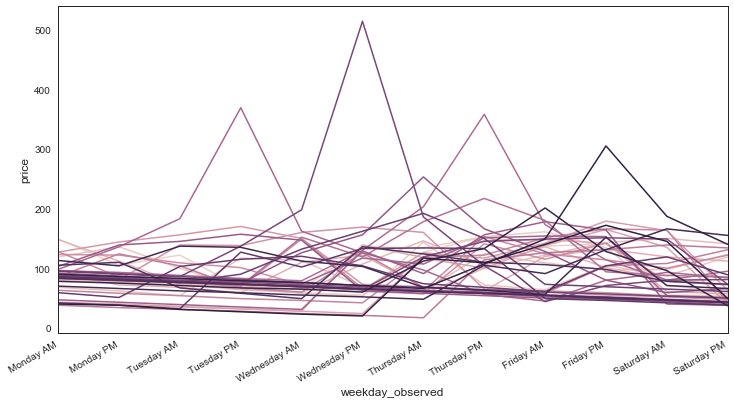

In [50]:
plt.figure(figsize=(12, 6))
combined_sell_data_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='trend_id',
    data=combined_sell_data, 
    sort=False,
    legend=False
)

combined_sell_data_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()

In [58]:
pivot_table = pivot(combined_sell_data, is_combined_data=True)
display(pivot_table)

def is_decreasing(data):
    decreasing = np.all(data[:, 1:] < data[:, :-1], axis=1)
    return decreasing

# display(pivot_table)
pivot_numpy = pivot_table.to_numpy()
states = is_decreasing(pivot_numpy)
decreasing_indices = np.where(states)[0]

# change 'index' column name to avoid confusion with actual index

weekday_observed,Monday AM,Monday PM,Tuesday AM,Tuesday PM,Wednesday AM,Wednesday PM,Thursday AM,Thursday PM,Friday AM,Friday PM,Saturday AM,Saturday PM
trend_id,,,,,,,,,,,,
0,149.0,105.0,122.0,68.0,59.0,55.0,127.0,153.0,137.0,141.0,71.0,60.0
1,81.0,77.0,74.0,69.0,65.0,136.0,134.0,153.0,161.0,134.0,55.0,54.0
2,119.0,136.0,100.0,68.0,58.0,53.0,144.0,72.0,64.0,105.0,87.0,119.0
3,68.0,62.0,54.0,117.0,113.0,69.0,62.0,124.0,109.0,97.0,98.0,123.0
4,80.0,76.0,72.0,70.0,65.0,61.0,57.0,100.0,122.0,143.0,150.0,141.0
5,148.0,112.0,73.0,64.0,59.0,107.0,146.0,105.0,136.0,101.0,81.0,73.0
6,92.0,72.0,68.0,59.0,110.0,122.0,68.0,62.0,120.0,132.0,119.0,112.0
7,43.0,40.0,36.0,32.0,28.0,139.0,118.0,146.0,148.0,142.0,61.0,57.0
8,42.0,39.0,35.0,32.0,28.0,24.0,117.0,100.0,138.0,165.0,135.0,40.0


In [ ]:
a = combined_sell_data.index[combined_sell_data['index'].isin(decreasing_indices)].tolist()

plt.figure(figsize=(12, 6))
decreasing_trend_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='index', 
    data=combined_sell_data.loc[a, :], 
    sort=False,
    legend=False
)
decreasing_trend_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()